# Using Machine Learning to Create Price Prediction for Tokyo Based Real Estate Company with Python

## Part A: Data Processing and Exploratory Data Analysis (EDA)

##### By Shahin Karami

This Notebook is split into 2 steps. Step 1 will take Real Estate Data from Tokyo Japan (data is sourced from Kaggle) and prepare it for EDA, Correlation analysis, and eventually Regression analysis using Machine Learning. I will focus on removing unnecessary columns, duplicate values and missing values. Once the data is properly cleaned I move to Step 2, which is to conduct basic EDA with the help of `SweetViz`. I also remove outliers using the Median Absolute Deviation. By the conclusion of this notebook I will have prepped the data for all forms of analysis, and will have taken the first step in that analysis via  EDA. 
<hr>

## Step 1: Data Preprocessing

First I will prep the data for EDA. 

### 1 - Imports and Data Import

The data used for this project comes [Kaggle](https://www.kaggle.com/datasets/nishiodens/japan-real-estate-transaction-prices).  The Kaggle Dataset has real estate data from all 47 prefectures in Japan. For this project I use a subsample of the Tokyo prefecture data that only has 20,000 data points.

In [1]:
import pickle
import matplotlib
from scipy.stats import median_abs_deviation 

import pandas as pd
import numpy as np
import sweetviz as sv
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.pyplot import figure

plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv('TokyoSub.csv')

<hr>

### 2 - Removing Unessasary Columns

First I observe the dimensionality of the data, then I proceed to remove the columns that I will not be using for EDA.

In [3]:
df.shape

(20000, 35)

In [4]:
df = df.drop(['MunicipalityCode', 'Prefecture', 'Region', 'DistrictName', 'NearestStation','MinTimeToNearestStation', 'MaxTimeToNearestStation',
              'AreaIsGreaterFlag', 'FrontageIsGreaterFlag', 'TotalFloorArea',
              'TotalFloorAreaIsGreaterFlag', 'PrewarBuilding', 'Purpose', 'Classification', 'Breadth',
              'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Period', 'Year','Quarter','Remarks'] , axis = 1)

In [5]:
df.head(5)

,Type,Municipality,TimeToNearestStation,TradePrice,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
0,"Pre-owned Condominiums, etc.",Chiyoda Ward,4,40000000,1LDK,30,NaN,NaN,2013.0,RC,House,NaN,Not yet
1,"Pre-owned Condominiums, etc.",Chiyoda Ward,4,130000000,3LDK,80,NaN,NaN,2007.0,RC,NaN,NaN,Done
2,Residential Land(Land and Building),Chiyoda Ward,2,400000000,NaN,110,Trapezoidal Shaped,9.0,2018.0,S,"Office, Shop",Northwest,NaN
3,Residential Land(Land and Building),Chiyoda Ward,1,180000000,NaN,50,Rectangular Shaped,5.2,1976.0,RC,"Housing Complex, Office",Southwest,NaN
4,"Pre-owned Condominiums, etc.",Chiyoda Ward,4,100000000,2LDK,65,NaN,NaN,2007.0,RC,House,NaN,Done


<hr>

### 3 - Change Column’s Name

I rename some columns to make the data easier to interpret. I change the name of the column based on the following:
* `TimeToNearestStation`: `MinuteToClosestStation`
* `TradePrice`: `Price`

In [6]:
col_name = ['Type', 'Municipality','MinuteToClosestStation',
       'Price', 'FloorPlan', 'Area', 'LandShape', 'Frontage',
       'BuildingYear', 'Structure', 'Use', 'Direction', 'Renovation']

df.columns = col_name
df.head(5)

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
0,"Pre-owned Condominiums, etc.",Chiyoda Ward,4,40000000,1LDK,30,NaN,NaN,2013.0,RC,House,NaN,Not yet
1,"Pre-owned Condominiums, etc.",Chiyoda Ward,4,130000000,3LDK,80,NaN,NaN,2007.0,RC,NaN,NaN,Done
2,Residential Land(Land and Building),Chiyoda Ward,2,400000000,NaN,110,Trapezoidal Shaped,9.0,2018.0,S,"Office, Shop",Northwest,NaN
3,Residential Land(Land and Building),Chiyoda Ward,1,180000000,NaN,50,Rectangular Shaped,5.2,1976.0,RC,"Housing Complex, Office",Southwest,NaN
4,"Pre-owned Condominiums, etc.",Chiyoda Ward,4,100000000,2LDK,65,NaN,NaN,2007.0,RC,House,NaN,Done


<hr>

### 4 - Dealing with Missing Values

I create a for loop to iterate among all columns to determine whether they have any `NaN` or not. This Loop provides the number of null values in every single column as well as the percentage of null values.

In [7]:
for col in df.columns:
    number_null = df.loc[: , col].isnull().sum()
    perc_null = (number_null / df.shape[0]) * 100
    print('{} -- {} -- {}%'.format(col, number_null, round(perc_null,3)))

Type -- 0 -- 0.0%
Municipality -- 0 -- 0.0%
MinuteToClosestStation -- 137 -- 0.685%
Price -- 0 -- 0.0%
FloorPlan -- 3153 -- 15.765%
Area -- 0 -- 0.0%
LandShape -- 16848 -- 84.24%
Frontage -- 17053 -- 85.265%
BuildingYear -- 710 -- 3.55%
Structure -- 488 -- 2.44%
Use -- 2208 -- 11.04%
Direction -- 16847 -- 84.235%
Renovation -- 4917 -- 24.585%


The result  above shows we have a wide range of `NaN` present in the data. Some features contain a small amount of `NaN` while other contain a large amount of NaNs. Since I have a large dataset I have created a trivial breakdown of how I will go about it the `NaN` within each feature:
<br><br>
**Numerical Features:**
* between 0% and 30%, I impute with mean or median.
* More than 30%, I drop the rows.
<br><br>

**Categorical Features:**
* less than 5%, I drop the rows.
* between 5% and 30%, I impute with mode.
* More than 30%, create a new label as `Other`.
<br>

__NOTE:__ *By no means do I claim this method to be the 'correct' method. However, for the sake of this project this method will suffice*.

I first focus on the categorical values. I impute `Renovation`, `FloorPlan` and `Use` with mode.

In [8]:
mode_Renovation = df['Renovation'].mode()[0]
mode_Use = df['Use'].mode()[0]
mode_FloorPlan = df['FloorPlan'].mode()[0]

print(mode_Renovation)
print(mode_Use)
print(mode_FloorPlan)

Not yet
House
1K


In [9]:
df['Renovation'] = df['Renovation'].fillna('Not yet')
df['Use'] = df['Use'].fillna('House')
df['FloorPlan'] = df['FloorPlan'].fillna('1K')

Then, I created a new label for missing values in `LandShape` and `Direction`.

In [10]:
df['LandShape'] = df['LandShape'].fillna('Other LandShape')
df['Direction'] = df['Direction'].fillna('Other Direction')

Lastly, I drop any row with `NaNs` in the `Structure` columns

In [11]:
df = df.dropna(subset = ['Structure'])

<hr>

Now, I will shift my focus to the Numerical Features. I will impute `MinuteToClosestStation` and `BuildingYear` . However, before doing this, I must make sure about distribution shape of these columns to see whether they are right-skewed or left-skewed. It can be helpful when I want to decide choosing mean or median for imputing. Also, I will check the data type of theses variables to confirm their numerical type.

In [12]:
print(df['MinuteToClosestStation'].dtypes)
print(df['BuildingYear'].dtypes)

object
float64


`MinuteToClosestStation` is an object type. This means there are some non-numerical values in this column. This should be handled first. Below we will confirm the presense of non-numerical values and instruct python to coerce those instances as a `NaN`. 

In [13]:
df['MinuteToClosestStation'].unique()

array(['4', '2', '1', nan, '3', '5', '6', '0', '7', '11', '10', '8', '9',
       '12', '30-60minutes', '13', '14', '16', '15', '19', '18', '21',
       '2H-', '17'], dtype=object)

In [14]:
df['MinuteToClosestStation'] = pd.to_numeric(df['MinuteToClosestStation'], errors='coerce')
df['MinuteToClosestStation'].unique()

array([ 4.,  2.,  1., nan,  3.,  5.,  6.,  0.,  7., 11., 10.,  8.,  9.,
       12., 13., 14., 16., 15., 19., 18., 21., 17.])

Now we can see its distribution to determine whether to use Mean or Median

In [15]:
skewness_MTCS = round(df['MinuteToClosestStation'].skew() ,3)
print('Skewness :' , skewness_MTCS)

def approximately_zero(skewness, tolerance= 1):
    if abs(skewness) <= tolerance:
        print("The data is not heavily skewed, use the Mean. ")
    else:
        print("The data is heavily skewed, use the Median. ")
    return

approximately_zero(skewness_MTCS)

Skewness : 1.103
The data is heavily skewed, use the Median. 


The result above tells me that I should opt to use the Median when I impute.

In [16]:
df['MinuteToClosestStation'] = df['MinuteToClosestStation'].fillna(df['MinuteToClosestStation'].median()).round(0)

Next I run the same process for `BuildingYear` 

In [17]:
skewness_BY = round(df['BuildingYear'].skew() ,3)
print('Skewness :' , skewness_BY)

approximately_zero(skewness_BY)

Skewness : -0.933
The data is not heavily skewed, use the Mean. 


The result above tells me that I should opt to use the Mean when I impute.

In [18]:
df['BuildingYear'] = df['BuildingYear'].fillna(df['BuildingYear'].mean()).round(0)

The last change i need to do is to drop the `NaNs` found in the `Frontage` columns

In [19]:
df = df.dropna(subset = ['Frontage'])

<hr>

Now that I have completed all imputions I conduct I final check in the updated data.

In [20]:
for col in df.columns:
    number_null = df.loc[: , col].isnull().sum()
    perc_null = (number_null / df.shape[0]) * 100
    print('{} - {} - %{}'.format(col, number_null, round(perc_null,3)))

Type - 0 - %0.0
Municipality - 0 - %0.0
MinuteToClosestStation - 0 - %0.0
Price - 0 - %0.0
FloorPlan - 0 - %0.0
Area - 0 - %0.0
LandShape - 0 - %0.0
Frontage - 0 - %0.0
BuildingYear - 0 - %0.0
Structure - 0 - %0.0
Use - 0 - %0.0
Direction - 0 - %0.0
Renovation - 0 - %0.0


<hr>

### 5 - Removing any Duplicates Entries.

Now that all the `NaNs` have been handled, I can focus on removing any potential duplicated. I will first check to see if the data contains duplicates, then proceed accordingly.

In [21]:
duplicate_rows = df.duplicated()

if duplicate_rows.any():
    print("The DataFrame has duplicate rows.")
else:
    print("The DataFrame does not have duplicate rows.")

The DataFrame has duplicate rows.


Since we have duplicates rows, lets find them and list them out in a DataFrame

In [22]:
duplicate_rows = df[df.duplicated(keep = False)]
duplicate_rows = pd.DataFrame(duplicate_rows)
duplicate_rows

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
4986,Residential Land(Land and Building),Chuo Ward,2.0,230000000,1K,80,Rectangular Shaped,7.0,1964.0,SRC,Office,Northeast,Not yet
4994,Residential Land(Land and Building),Chuo Ward,2.0,230000000,1K,80,Rectangular Shaped,7.0,1964.0,SRC,Office,Northeast,Not yet
9353,Residential Land(Land and Building),Minato Ward,1.0,360000000,1K,160,Rectangular Shaped,8.9,1991.0,RC,"Housing Complex, Office, Shop",North,Not yet
9354,Residential Land(Land and Building),Minato Ward,1.0,360000000,1K,160,Rectangular Shaped,8.9,1991.0,RC,"Housing Complex, Office, Shop",North,Not yet
14686,Residential Land(Land and Building),Shinjuku Ward,5.0,59000000,1K,50,Rectangular Shaped,7.2,2015.0,W,House,North,Not yet
14690,Residential Land(Land and Building),Shinjuku Ward,5.0,59000000,1K,50,Rectangular Shaped,7.2,2015.0,W,House,North,Not yet
18342,Residential Land(Land and Building),Shinjuku Ward,4.0,400000000,1K,145,Semi-rectangular Shaped,9.5,2014.0,RC,Housing Complex,North,Not yet
18343,Residential Land(Land and Building),Shinjuku Ward,4.0,400000000,1K,145,Semi-rectangular Shaped,9.5,2014.0,RC,Housing Complex,North,Not yet


Now I check the shape of the data before and after dropping the duplicates. Finally I confirm that the data doesnt have any duplicates. 

In [23]:
print("before: ", df.shape)

df = df.drop_duplicates(keep='first')
print("after: ", df.shape)

before:  (2765, 13)
after:  (2761, 13)


In [24]:
duplicate_rows = df.duplicated()

if duplicate_rows.any():
    print("The DataFrame has duplicate rows.")
else:
    print("The DataFrame does not have duplicate rows.")

The DataFrame does not have duplicate rows.


<hr>

### 6 - Checking the Numerical Variables  

Now I want to check each numerical variable for any possible non-numerical values. This check is nessasary as numeric values can be classified as an `int`, `float`, or even a `str` The columns that are of intrest are: `Area`, `Frontage`, `MinuteToClosestStation`, `BuildingYear`, `Price`. Since I only have five numerical variables to check, I will manually check each one

In [25]:
print(df.Area.apply(type).value_counts())
print(df.Frontage.apply(type).value_counts())
print(df.MinuteToClosestStation.apply(type).value_counts())
print(df.BuildingYear.apply(type).value_counts())
print(df.Price.apply(type).value_counts())

<class 'int'>    2761
Name: Area, dtype: int64
<class 'float'>    2761
Name: Frontage, dtype: int64
<class 'float'>    2761
Name: MinuteToClosestStation, dtype: int64
<class 'float'>    2761
Name: BuildingYear, dtype: int64
<class 'int'>    2761
Name: Price, dtype: int64


Luckily, each numerical variable consist of either an `int` or `float`. Moreover, each variable has exactly 2761 values, which is the number of rows that our current dataframe, as seen below.

In [26]:
df.shape

(2761, 13)

<hr>

### 7 - Checking the Categorical Variables  

Lastly, I will check the values of the categoreical variable. These variables are: `Type`,`Municipality`, `FloorPlan`, `LandShape`, `Structure`, `Direction`, `Use`, `Renovation`. It is important to check the categorical variables as some may have  multiple values according to the documentations found on the Kaggle page associated with the data found [here](https://www.kaggle.com/datasets/nishiodens/japan-real-estate-transaction-prices).

#### Type 

In [27]:
print(df['Type'].unique())

['Residential Land(Land and Building)']


In [28]:
print(df['Type'].value_counts())

Residential Land(Land and Building)    2761
Name: Type, dtype: int64


#### Municipality

In [29]:
print(df['Municipality'].unique())

['Chiyoda Ward' 'Chuo Ward' 'Minato Ward' 'Shinjuku Ward' 'Bunkyo Ward']


In [30]:
print(df['Municipality'].value_counts())

Shinjuku Ward    1015
Minato Ward       660
Chuo Ward         581
Chiyoda Ward      434
Bunkyo Ward        71
Name: Municipality, dtype: int64


#### FloorPlan

In [31]:
print(df['FloorPlan'].unique())

['1K']


In [32]:
print(df['FloorPlan'].value_counts())

1K    2761
Name: FloorPlan, dtype: int64


#### LandShape

In [33]:
print(df['LandShape'].unique())

['Trapezoidal Shaped' 'Rectangular Shaped' 'Semi-rectangular Shaped'
 'Semi-trapezoidal Shaped' 'Irregular Shaped' 'Semi-shaped'
 'Semi-square Shaped' 'Flag-shaped etc.' 'Square Shaped' 'Other LandShape']


In [34]:
print(df['LandShape'].value_counts())

Semi-rectangular Shaped    1014
Rectangular Shaped          731
Irregular Shaped            423
Semi-trapezoidal Shaped     197
Semi-square Shaped          157
Semi-shaped                 111
Trapezoidal Shaped           78
Flag-shaped etc.             28
Square Shaped                21
Other LandShape               1
Name: LandShape, dtype: int64


#### Structure

In [35]:
print(df['Structure'].unique())

['S' 'RC' 'SRC' 'W' 'LS' 'S, LS' 'B' 'SRC, RC' 'S, W' 'RC, W' 'RC, S'
 'W, B']


It seems that some of the `Structure` values are a combination of two different Structure types (ex. `'S, LS'`). For simplicity my strategy will be to split these values up and only keep the first Structure type (ex. split `'S, LS'` and only keep `'S'`)

In [36]:
df['Structure'] = df['Structure'].apply(lambda x: x.split(',')[0])

In [37]:
print(df['Structure'].value_counts())

RC     1014
W       795
S       551
SRC     348
LS       50
B         3
Name: Structure, dtype: int64


#### Direction

In [38]:
print(df['Direction'].unique())

['Northwest' 'Southwest' 'South' 'Northeast' 'East' 'Southeast' 'West'
 'North' 'No facing road']


In [39]:
print(df['Direction'].value_counts())

Northwest         382
Southwest         373
Southeast         371
West              344
Northeast         335
South             329
East              307
North             304
No facing road     16
Name: Direction, dtype: int64


#### Use

In [40]:
print(df['Use'].unique())

['Office, Shop' 'Housing Complex, Office' 'House, Office, Workshop'
 'House, Office, Shop' 'Other' 'Office, Warehouse' 'Parking Lot'
 'Office, Parking Lot' 'Housing Complex, Office, Shop' 'House' 'Office'
 'Housing Complex' 'Housing Complex, Shop' 'House, Shop' 'Warehouse, Shop'
 'Housing Complex, Office, Warehouse, Shop' 'House, Workshop, Shop'
 'Warehouse' 'House, Office' 'Office, Warehouse, Parking Lot'
 'House, Factory, Office, Shop' 'House, Office, Other' 'Shop'
 'House, Office, Warehouse, Shop' 'Office, Other'
 'Office, Warehouse, Shop' 'House, Warehouse, Shop, Other' 'Workshop'
 'House, Office, Parking Lot' 'Office, Workshop, Warehouse' 'Factory'
 'House, Warehouse' 'House, Housing Complex, Factory, Warehouse'
 'Office, Parking Lot, Shop' 'House, Factory, Office'
 'Housing Complex, Office, Warehouse, Parking Lot'
 'House, Office, Warehouse' 'House, Workshop' 'House, Office, Shop, Other'
 'House, Parking Lot' 'House, Parking Lot, Shop'
 'Housing Complex, Parking Lot' 'Housing Com

Like with the `Structure` column, `Use` has entries that have a combination of values. Again, I will split them up and only consider the first `Use` value.  

In [41]:
df['Use'] = df['Use'].apply(lambda x: x.split(',')[0])

In [42]:
print(df['Use'].value_counts())

House              1300
Office              705
Housing Complex     559
Shop                117
Other                43
Warehouse            18
Factory               9
Parking Lot           6
Workshop              4
Name: Use, dtype: int64


#### Renovation

In [43]:
print(df['Renovation'].unique())

['Not yet']


In [44]:
print(df['Renovation'].value_counts())

Not yet    2761
Name: Renovation, dtype: int64


<hr>

## Step 2 Exploratory Data Analysis (EDA)

Now that the Data is properly cleaned I can conduct Exploratory Data Analysis. Once this is completed I can move to Corraltion analysis and building a ML model (which will be done in a seperate Notebook).

### 1 - Discriptive Statical Analysis with SweetViz package

I recently discovered the SweetViz package. SweetViz is an open-source Python library that generates beautiful, high-density visualizations to kickstart EDA (Exploratory Data Analysis) with just two lines of code. Output is a fully self-contained HTML application or can be embedded within a Jupyter Notebook.

I opt to include the SweetViz visualization within the notebook. The great thing about SweetViz output is that it is fully interactive. Each tab contains basic statistical analysis of a Variable from the DataFrame. The `ASSOCIATIONS` button will provide a correlation matrix.

                                             |          | [  0%]   00:00 -> (? left)


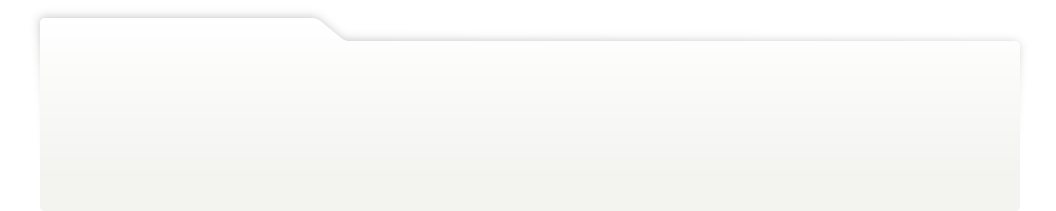
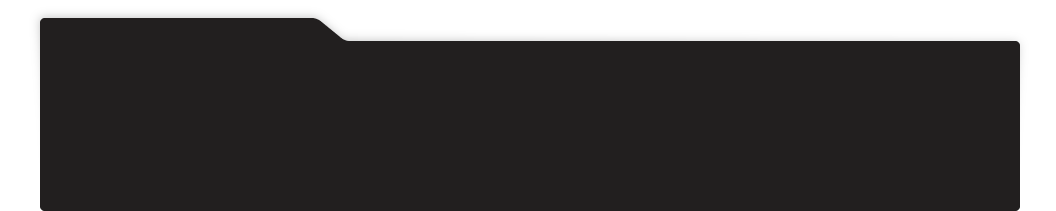
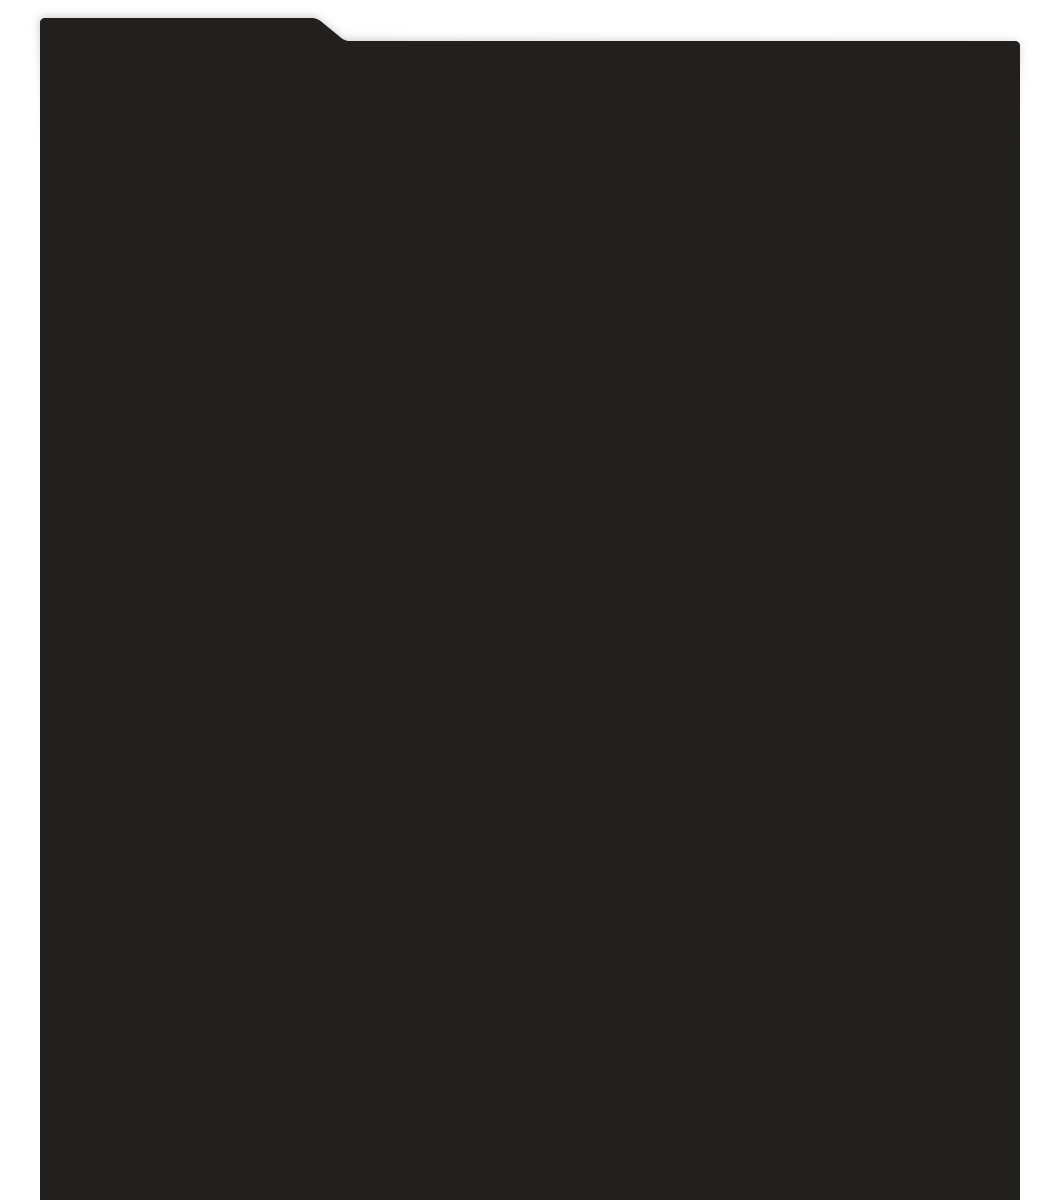
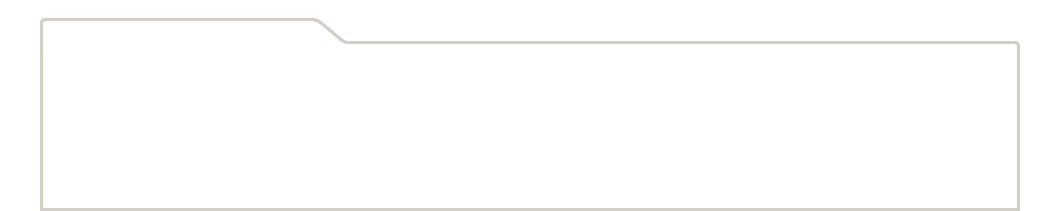
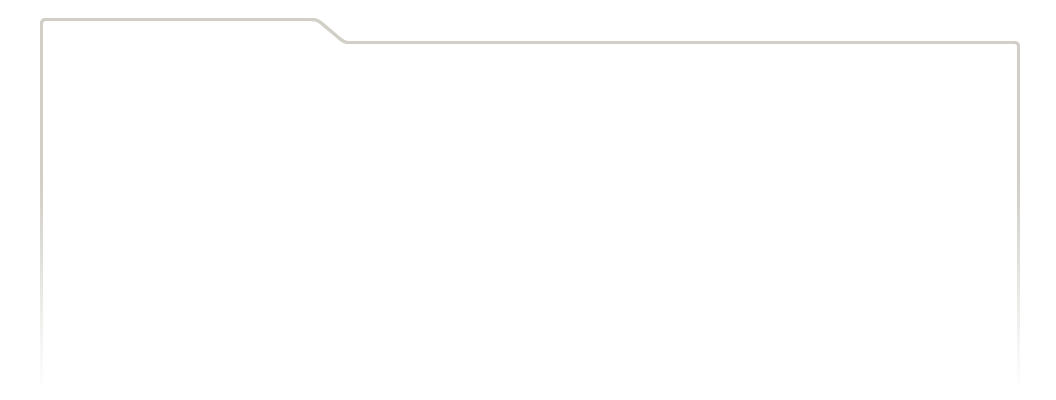
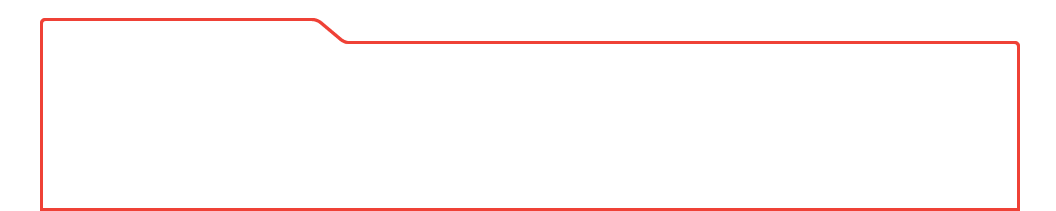
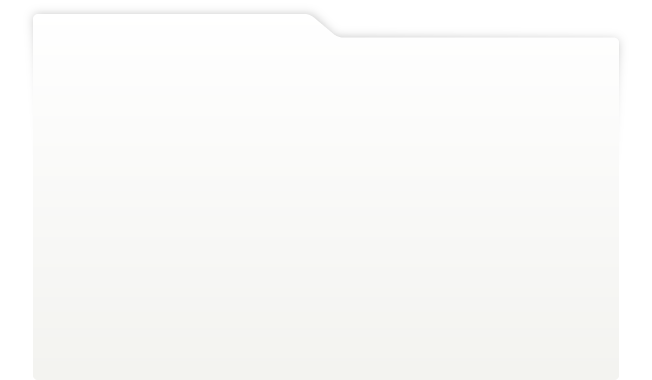
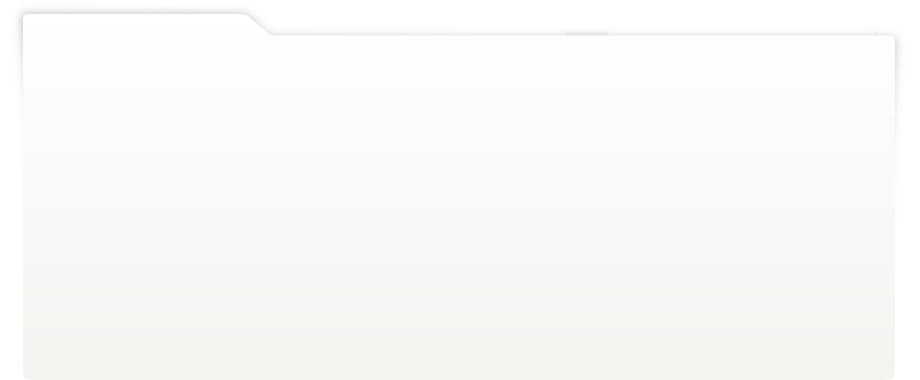
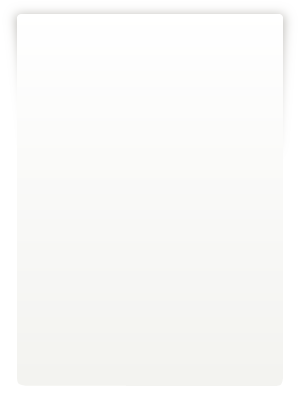
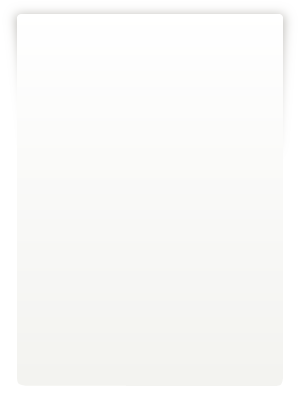
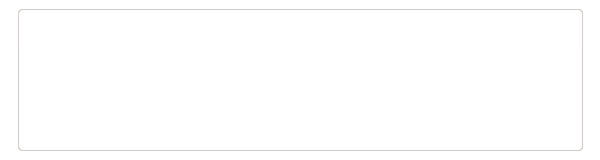
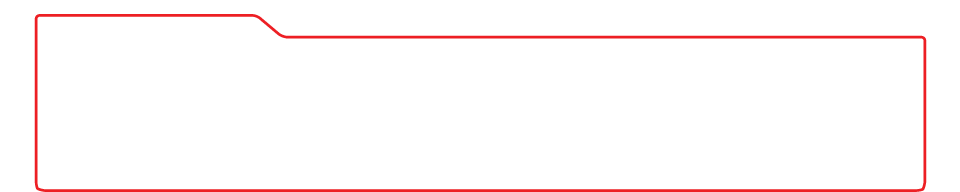
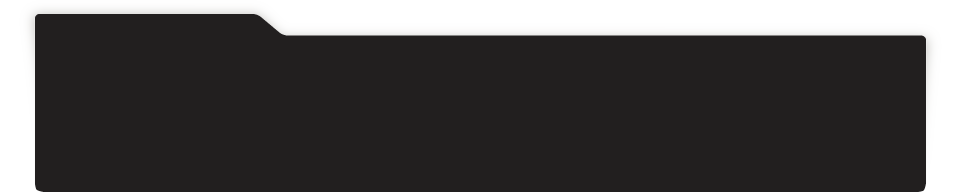
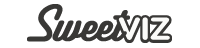
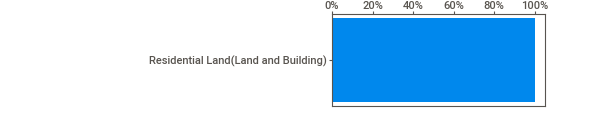
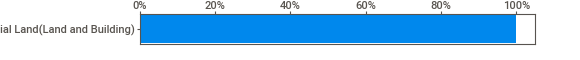
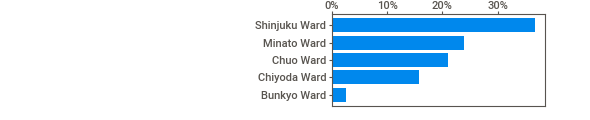
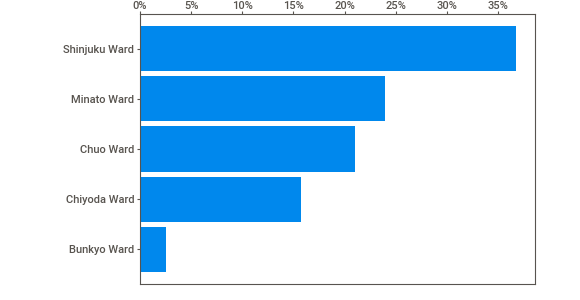
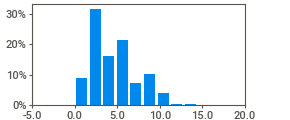
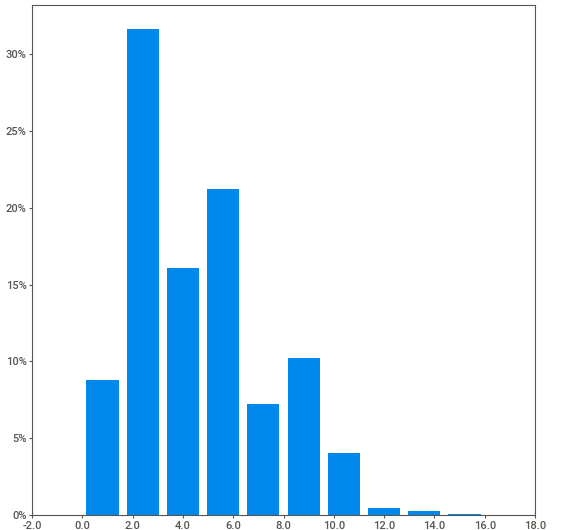
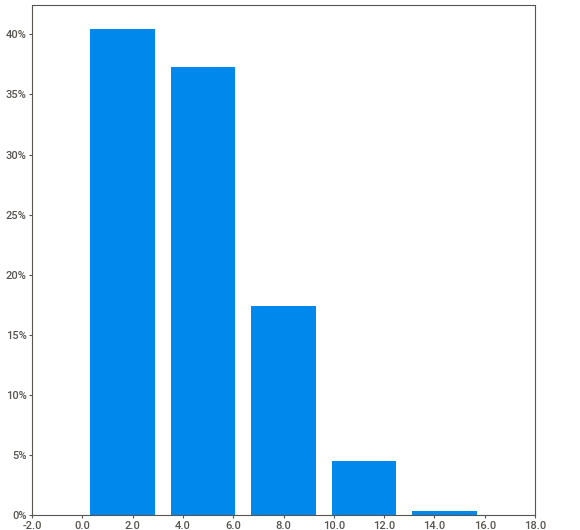
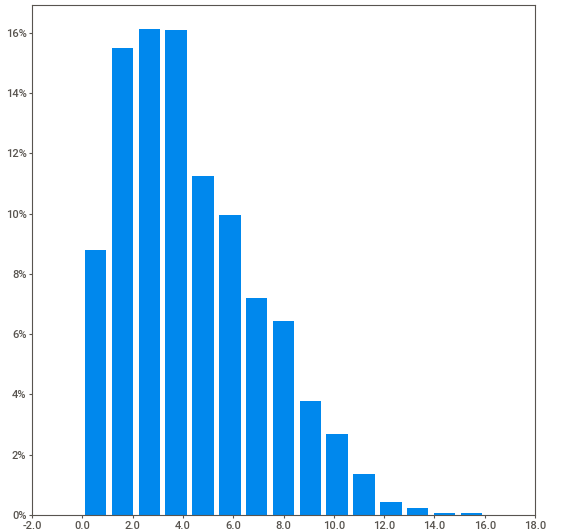
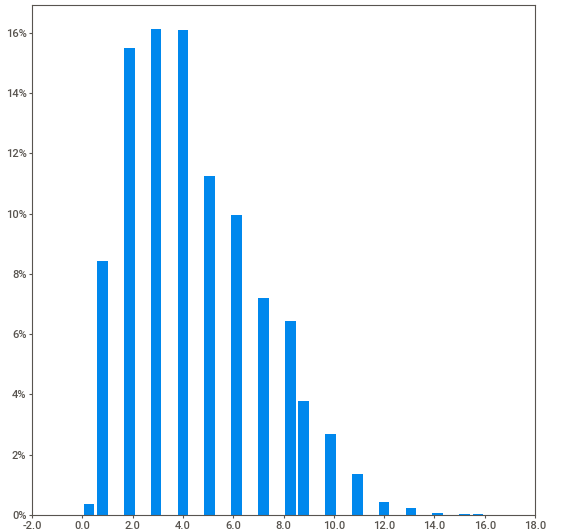
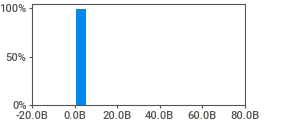
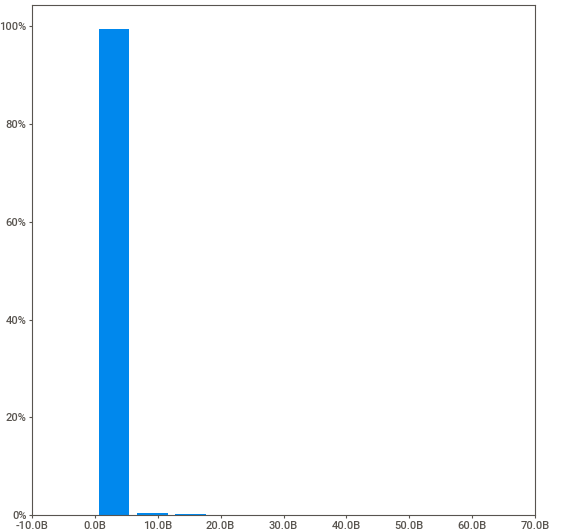
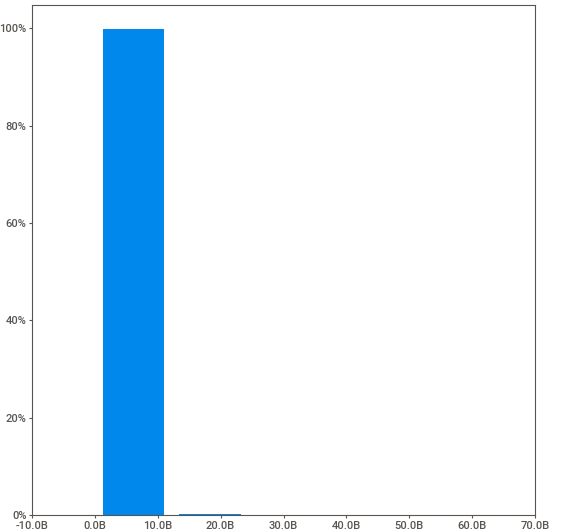
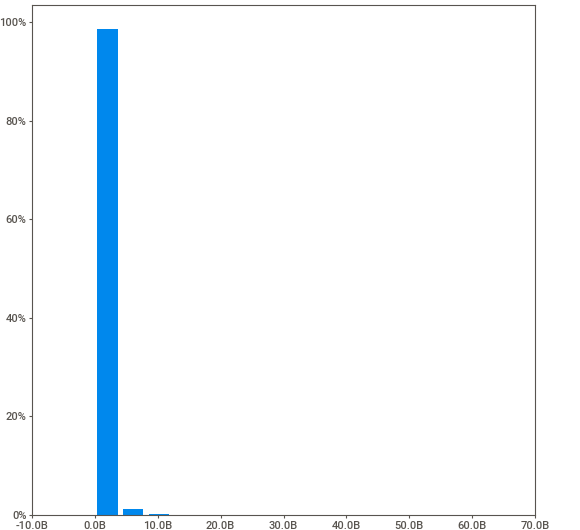
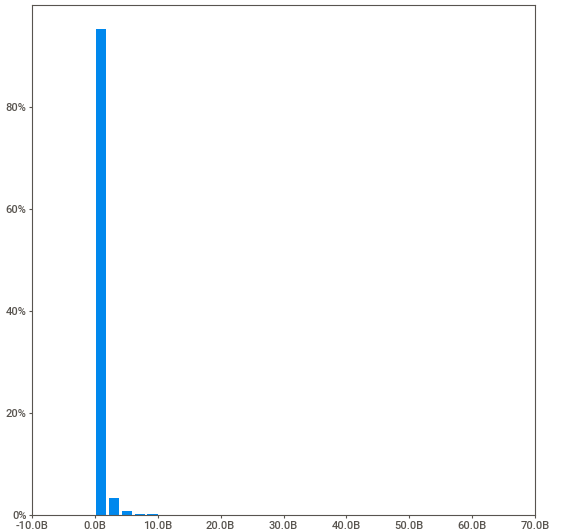
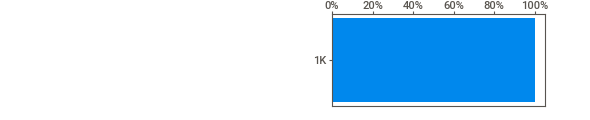
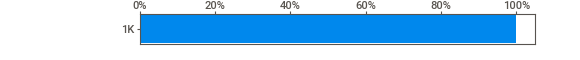
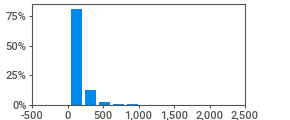
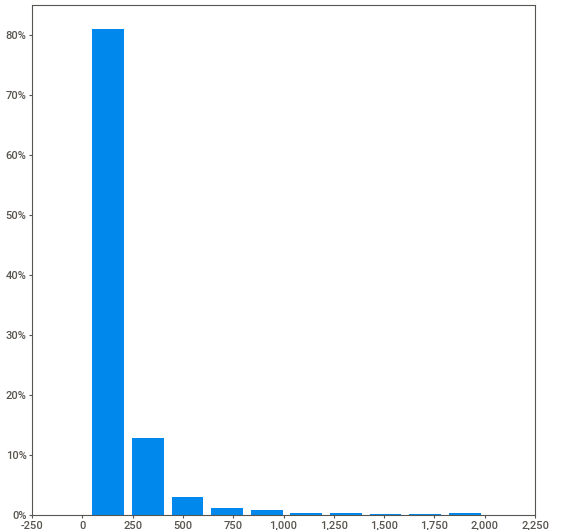
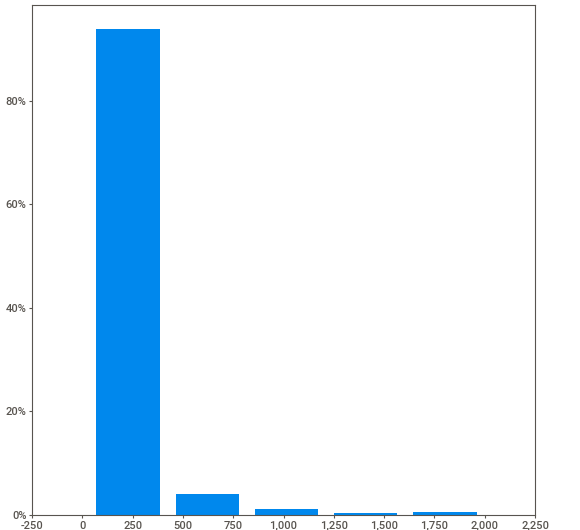
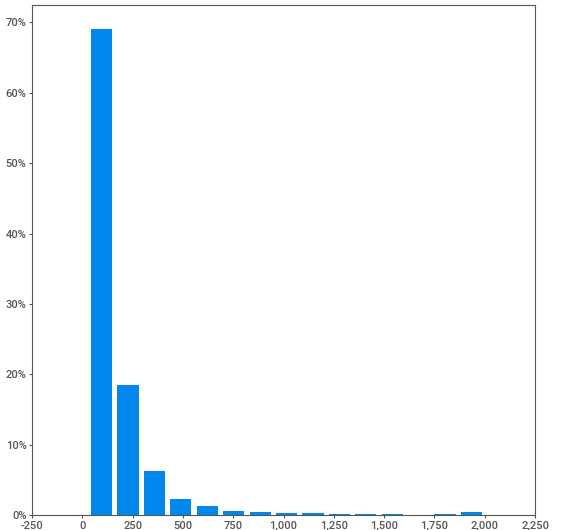
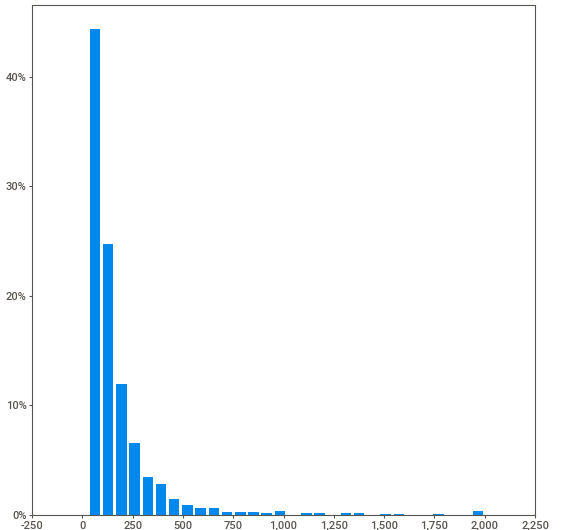
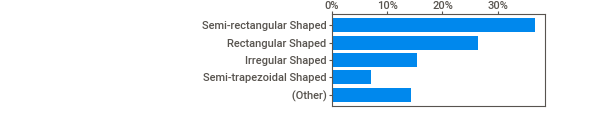
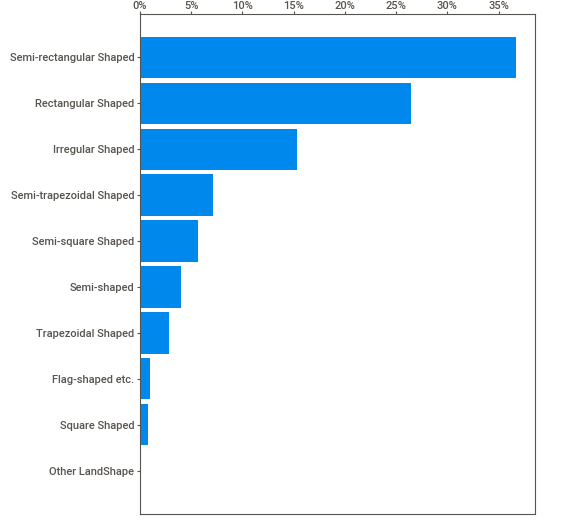
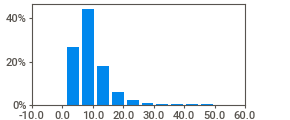
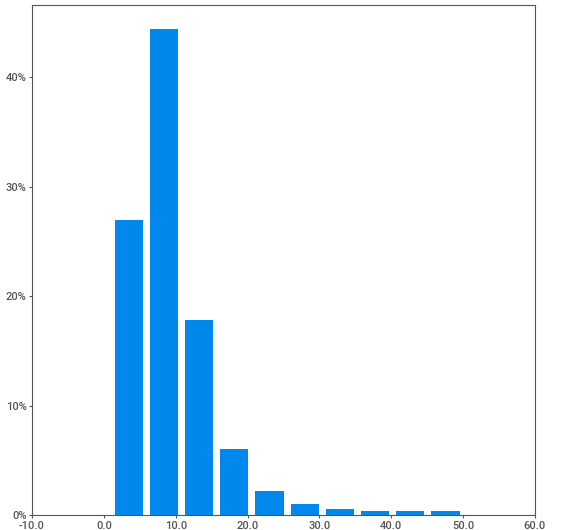
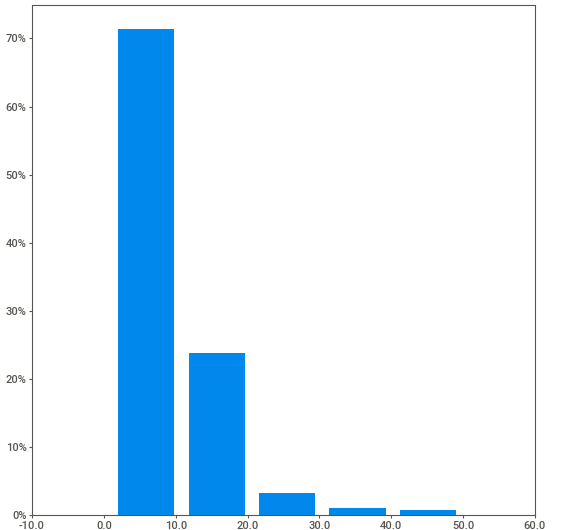
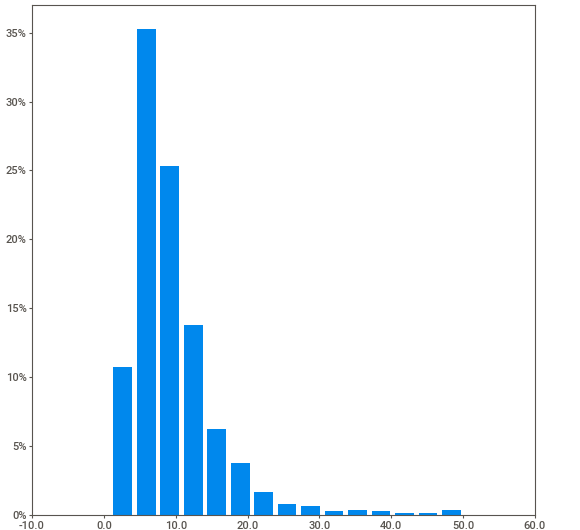
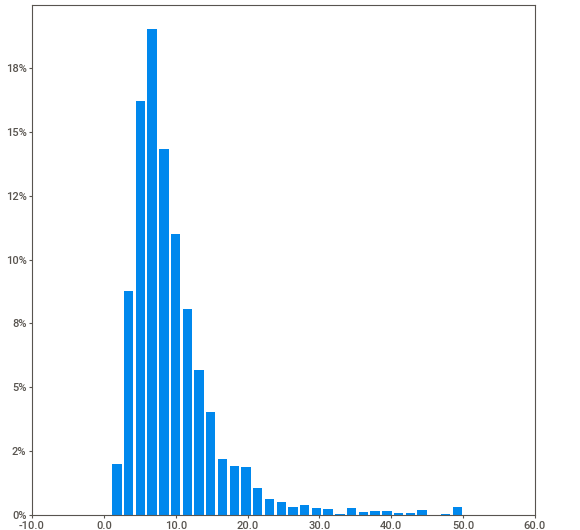
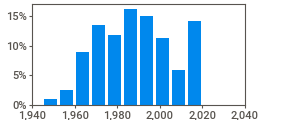
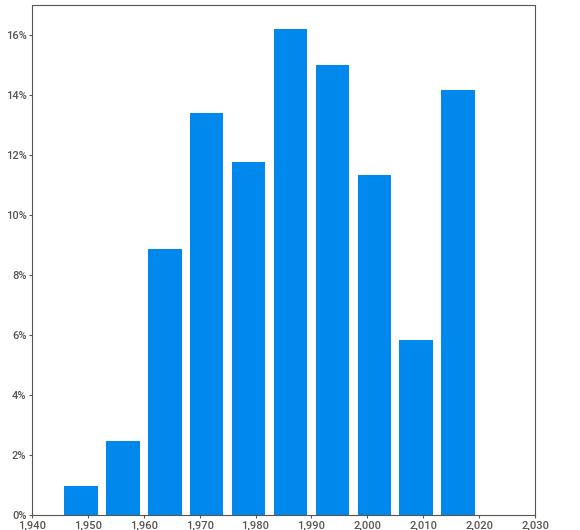
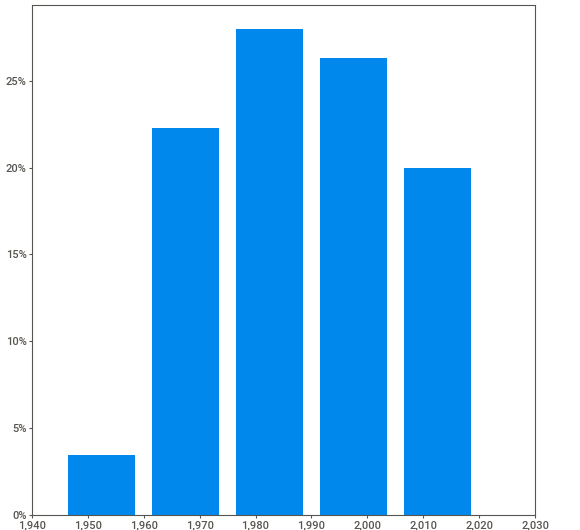
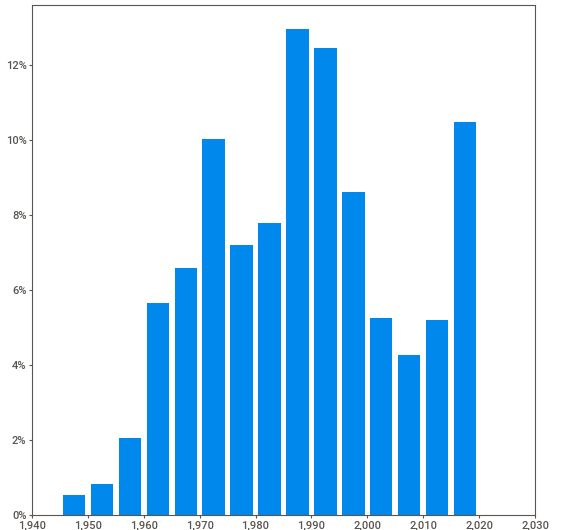
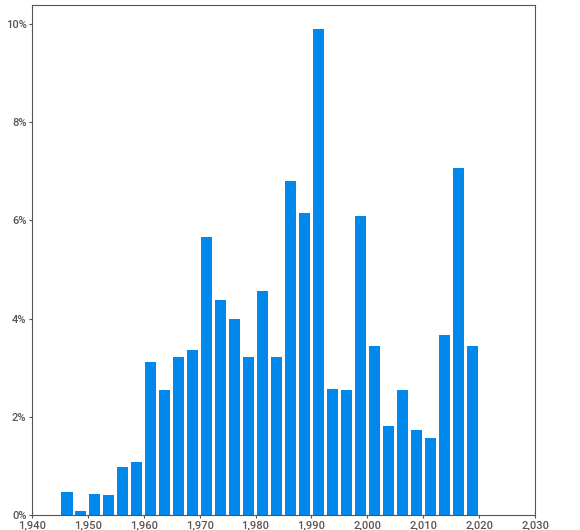
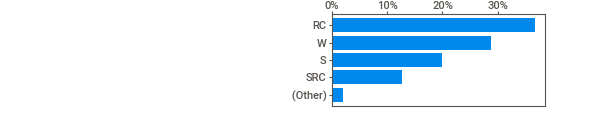
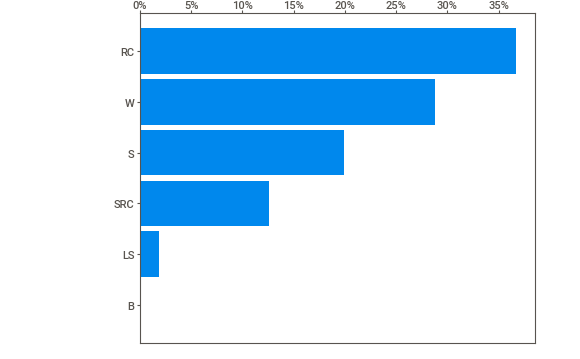
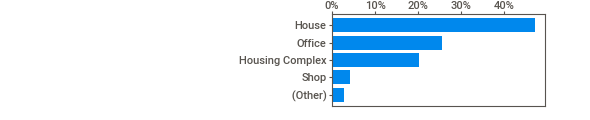
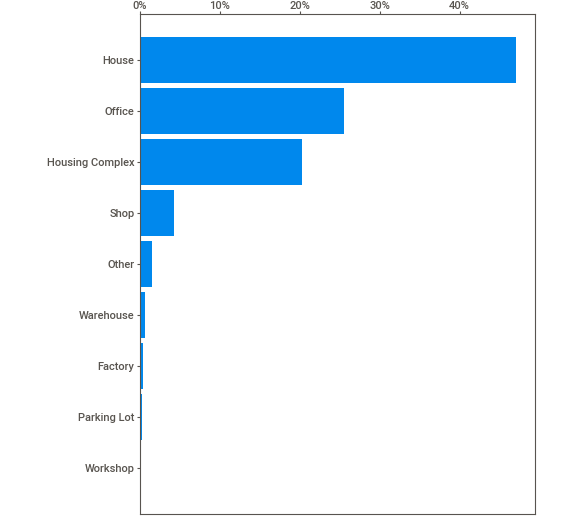
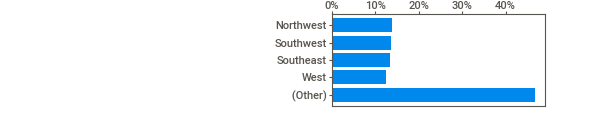
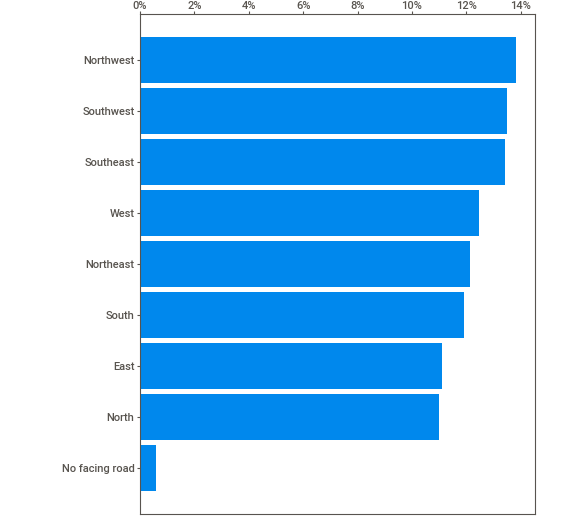
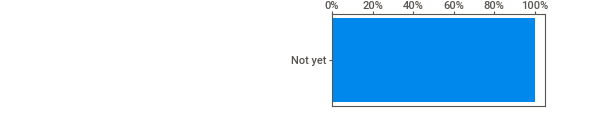
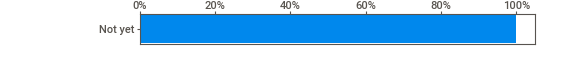
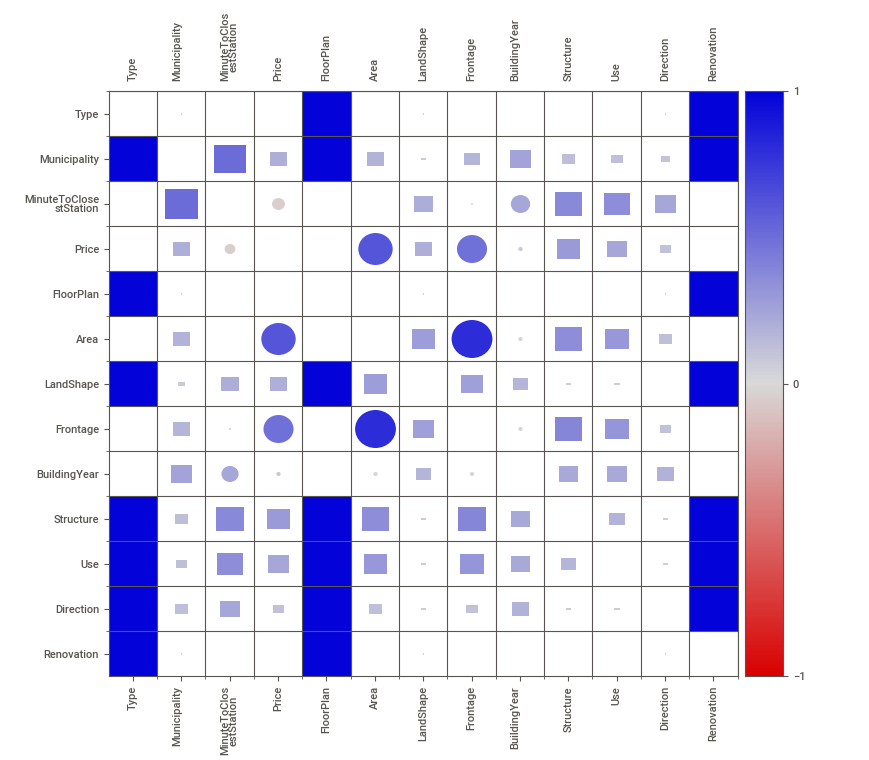
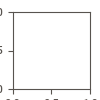

In [45]:
analyze_report = sv.analyze(df)
analyze_report.show_notebook()

<hr>

### 2 - Focusing in on Numerical Variables

I feel it is important to focus in on the Numerical variables a bit more than what SweetViz has outputted. Specifically I will create a KDE plot for each Numerical Variables as well as provide a written interpretation for each Numerical Variables. Below I will generate a KDE for the Numerical variables as well as provide some interpretations using the SweetViz output.  

First I create a function to plot the KDE along with the Mean in black and median in blue

In [46]:
def kde_plot(var):
    
    plt.figure(figsize = (8,5))
    sns.histplot(df[var], kde = True, color= 'green')
    sns.despine(left = True)
    
    mean = df[var].mean()
    median = df[var].median()
    
    plt.axvline(mean, color ='black', linestyle ='solid')
    plt.axvline(median, color ='blue', linestyle ='solid')
    plt.xlabel('')
    plt.ylabel('')
    plt.title("KDE plot of  {}".format(var))
    plt.legend
    
    return plt.show()

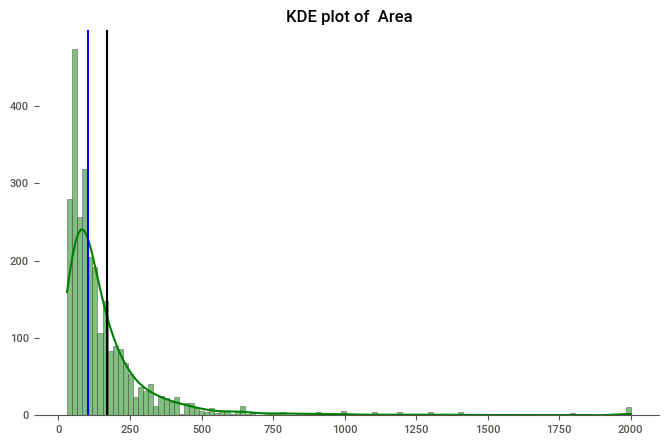

In [47]:
kde_plot('Area')

Notes on Area:
* The average Area is 170 square meters
* Maximum: 2000 square meters
* Minimum: 30 square meters
* Half of the real estate are less than 105 square meters
* 25% of the real estate have an area less than 65 square meters
* 75% of the real estate have an area greater than 190 square meters
* 50% of the real estate have an area between 65 and 190 square meters
* The KDE clearly shows that Area is skewed right

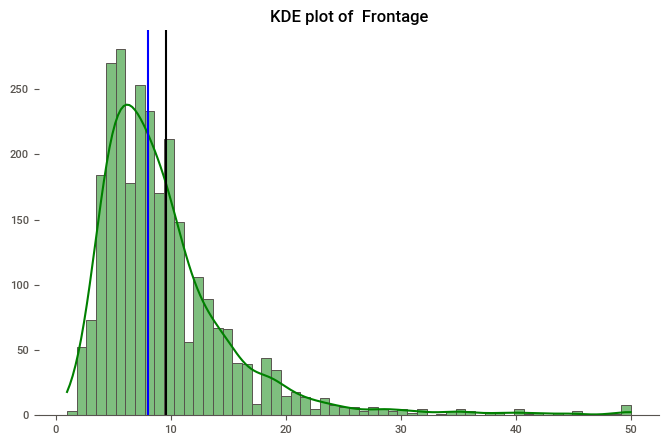

In [48]:
kde_plot('Frontage')

Notes on Frontage:
* The average Frontage is 9.6 meters
* Maximum: 50 meters
* Minimum: 1 meters
* Half of the real estate have Frontage that is less than 8 meters
* 25% of the real estate have Frontage that is less than 5.5 meters
* 75% of the real estate have Frontage that is greater than 11.5 meters
* 50% of the real estate have Frontage that is between 5.5 and 11.5 meters
* The KDE clearly shows that Frontage is skewed right

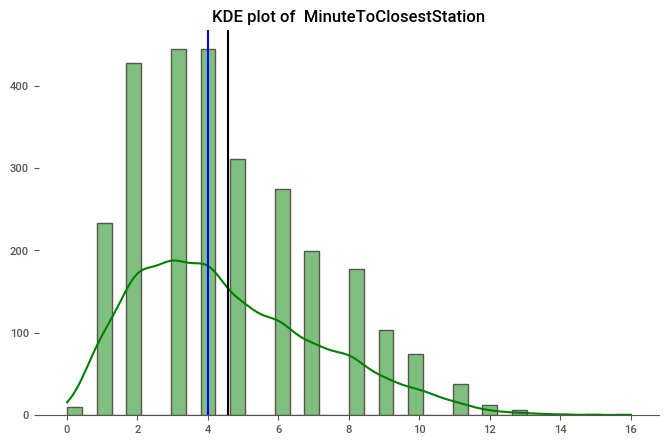

In [49]:
kde_plot('MinuteToClosestStation')

Notes on MinuteToClosestStation:
* The average time to nearest station is 4.6 minutes
* Maximum: 16 minutes to nearest station
* Minimum: less than 1 minute to nearest station
* Half of the real estate is less than 4 minutes to the nearest station
* 25% of the real estate is less than 3 minutes to the nearest station
* 75% of the real estate is greater than 6 minutes to the nearest station
* 50% of the real estate is between 3 and 6 minutes to the nearest station
* The KDE shows that the time to the nearest station resembles a normal distribution but is skewed right

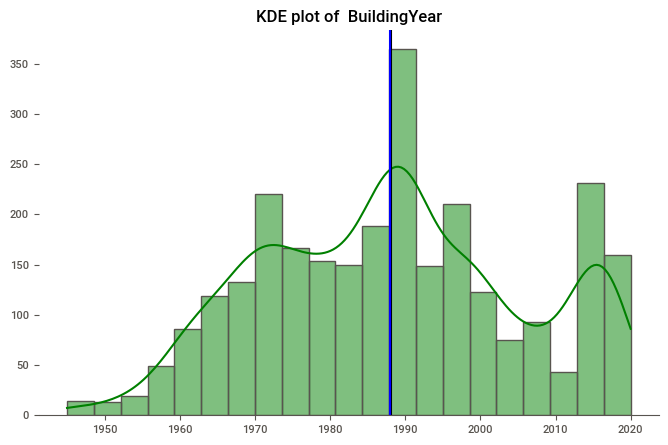

In [50]:
kde_plot('BuildingYear')

Notes on BuildingYear:
* The average year to build is 1987
* Maximum: The newest house was built in 2020
* Minimum: The oldest house was built in 1945
* Half of all the real estate was built before 1988
* 25% of all the real estate was built before or on 1974
* 75% of all the real estate was built before or on 2000 
* 50% of all the real estate was built between 1974 and 2000
* The KDE shows that the distribution of building year is somewhere between a normal and bimodal distribution

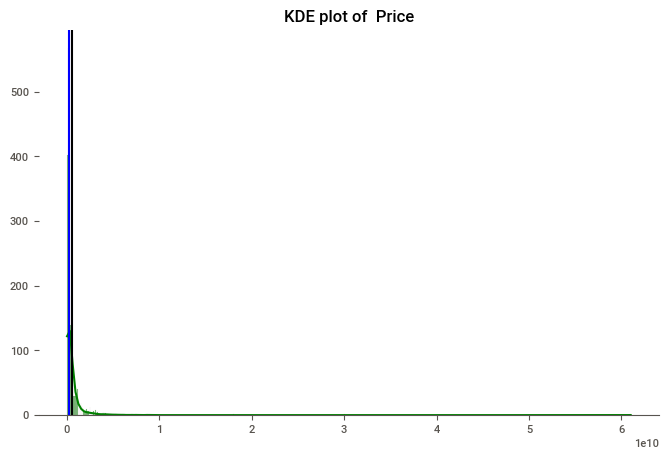

In [51]:
kde_plot('Price')

Notes on Price:
* The average price was 0.5 billion Yen
* Maximum: 61 Billion Yen
* Minimum: 0Billion Yen
* Half of all the real estate is worth less than 0.2 billion Yen
* 25% of all the real estate is worth less than 0.1 billion Yen
* 75% of all the real estate is worth less than 0.5 billion Yen 
* 50% of all the real estate is worth between 0.1 and 0.5
* The KDE shows that the distribution of price is extremely skewed right

<hr>

Now I will present the real estate with the maximum and minimums of each numerical value. This is just so we can conduct some more of a visual analysis of the properties with maximum and minimum numerical traits. 

##### Minimum Area

In [52]:
df[df['Area'] == df['Area'].min()]

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
419,Residential Land(Land and Building),Chiyoda Ward,2.0,17000000,1K,30,Rectangular Shaped,4.3,1968.0,S,Office,South,Not yet
2461,Residential Land(Land and Building),Chuo Ward,1.0,320000000,1K,30,Rectangular Shaped,3.5,1989.0,S,Office,Southwest,Not yet
2499,Residential Land(Land and Building),Chuo Ward,2.0,190000000,1K,30,Semi-rectangular Shaped,4.0,1979.0,SRC,Office,Southwest,Not yet
2525,Residential Land(Land and Building),Chuo Ward,2.0,120000000,1K,30,Trapezoidal Shaped,5.0,1977.0,S,House,Southwest,Not yet
3387,Residential Land(Land and Building),Chuo Ward,2.0,50000000,1K,30,Rectangular Shaped,3.9,1998.0,W,House,Southeast,Not yet
3388,Residential Land(Land and Building),Chuo Ward,2.0,51000000,1K,30,Rectangular Shaped,3.9,1998.0,W,House,Southeast,Not yet
5213,Residential Land(Land and Building),Chuo Ward,3.0,150000000,1K,30,Semi-rectangular Shaped,3.0,1962.0,W,House,Southeast,Not yet
5832,Residential Land(Land and Building),Chuo Ward,3.0,36000000,1K,30,Rectangular Shaped,3.9,1963.0,W,House,Northeast,Not yet
8425,Residential Land(Land and Building),Minato Ward,8.0,43000000,1K,30,Semi-shaped,5.5,1972.0,W,House,Northeast,Not yet
9040,Residential Land(Land and Building),Minato Ward,4.0,27000000,1K,30,Semi-rectangular Shaped,7.3,1993.0,RC,Housing Complex,Southeast,Not yet


##### Maximum Area

In [53]:
df[df['Area'] == df['Area'].max()]

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
1053,Residential Land(Land and Building),Chiyoda Ward,6.0,7000000000,1K,2000,Rectangular Shaped,41.5,1995.0,SRC,Office,West,Not yet
6465,Residential Land(Land and Building),Minato Ward,1.0,30000000000,1K,2000,Irregular Shaped,50.0,2001.0,SRC,Office,West,Not yet
6662,Residential Land(Land and Building),Minato Ward,7.0,7500000000,1K,2000,Irregular Shaped,34.0,1978.0,RC,House,North,Not yet
9930,Residential Land(Land and Building),Minato Ward,3.0,6600000000,1K,2000,Semi-rectangular Shaped,50.0,1998.0,S,Office,North,Not yet
11060,Residential Land(Land and Building),Minato Ward,9.0,4700000000,1K,2000,Irregular Shaped,31.0,1969.0,RC,Office,East,Not yet
15053,Residential Land(Land and Building),Minato Ward,6.0,7000000000,1K,2000,Semi-square Shaped,45.0,1977.0,RC,Office,Northeast,Not yet
15142,Residential Land(Land and Building),Minato Ward,1.0,4000000000,1K,2000,Semi-rectangular Shaped,42.0,1961.0,RC,Warehouse,Southeast,Not yet
15812,Residential Land(Land and Building),Chuo Ward,7.0,14000000000,1K,2000,Semi-shaped,50.0,2010.0,S,Office,West,Not yet
17597,Residential Land(Land and Building),Shinjuku Ward,5.0,3900000000,1K,2000,Semi-shaped,50.0,2012.0,RC,Office,West,Not yet
17778,Residential Land(Land and Building),Shinjuku Ward,9.0,4400000000,1K,2000,Irregular Shaped,50.0,1971.0,RC,Other,West,Not yet


##### Minimum Frontage

In [54]:
df[df['Frontage'] == df['Frontage'].min()]

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
17351,Residential Land(Land and Building),Shinjuku Ward,8.0,7600000,1K,40,Flag-shaped etc.,1.0,1948.0,W,Housing Complex,East,Not yet


##### Maximum Frontage

In [55]:
df[df['Frontage'] == df['Frontage'].max()]

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
6465,Residential Land(Land and Building),Minato Ward,1.0,30000000000,1K,2000,Irregular Shaped,50.0,2001.0,SRC,Office,West,Not yet
9930,Residential Land(Land and Building),Minato Ward,3.0,6600000000,1K,2000,Semi-rectangular Shaped,50.0,1998.0,S,Office,North,Not yet
15812,Residential Land(Land and Building),Chuo Ward,7.0,14000000000,1K,2000,Semi-shaped,50.0,2010.0,S,Office,West,Not yet
16263,Residential Land(Land and Building),Minato Ward,3.0,2700000000,1K,1300,Semi-rectangular Shaped,50.0,1985.0,SRC,Office,South,Not yet
16268,Residential Land(Land and Building),Shinjuku Ward,6.0,1900000000,1K,1400,Semi-rectangular Shaped,50.0,1989.0,RC,Office,North,Not yet
17597,Residential Land(Land and Building),Shinjuku Ward,5.0,3900000000,1K,2000,Semi-shaped,50.0,2012.0,RC,Office,West,Not yet
17778,Residential Land(Land and Building),Shinjuku Ward,9.0,4400000000,1K,2000,Irregular Shaped,50.0,1971.0,RC,Other,West,Not yet
18711,Residential Land(Land and Building),Minato Ward,4.0,61000000000,1K,2000,Irregular Shaped,50.0,1993.0,SRC,Housing Complex,Southwest,Not yet


##### Minimum Time to Nearest Station

In [56]:
df[df['MinuteToClosestStation'] == df['MinuteToClosestStation'].min()]

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
3722,Residential Land(Land and Building),Chuo Ward,0.0,3800000000,1K,390,Semi-rectangular Shaped,12.9,1994.0,SRC,Office,Southeast,Not yet
4961,Residential Land(Land and Building),Chuo Ward,0.0,140000000,1K,50,Semi-rectangular Shaped,4.0,1998.0,RC,House,Southeast,Not yet
5181,Residential Land(Land and Building),Chuo Ward,0.0,2500000000,1K,470,Irregular Shaped,13.0,1976.0,SRC,House,Northwest,Not yet
5259,Residential Land(Land and Building),Chuo Ward,0.0,58000000,1K,60,Rectangular Shaped,6.2,1998.0,S,House,North,Not yet
5790,Residential Land(Land and Building),Chuo Ward,0.0,110000000,1K,45,Rectangular Shaped,3.5,2015.0,S,Office,Southwest,Not yet
13500,Residential Land(Land and Building),Chuo Ward,0.0,200000000,1K,55,Semi-rectangular Shaped,4.0,1993.0,SRC,Office,Southeast,Not yet
14363,Residential Land(Land and Building),Shinjuku Ward,0.0,2300000000,1K,240,Semi-trapezoidal Shaped,11.4,2009.0,SRC,Office,West,Not yet
18406,Residential Land(Land and Building),Shinjuku Ward,0.0,140000000,1K,30,Irregular Shaped,7.0,1973.0,RC,House,North,Not yet
18614,Residential Land(Land and Building),Minato Ward,0.0,2300000000,1K,300,Rectangular Shaped,14.0,1989.0,S,Office,Southeast,Not yet
19603,Residential Land(Land and Building),Minato Ward,0.0,520000000,1K,75,Trapezoidal Shaped,8.5,1968.0,RC,Office,Southwest,Not yet


##### Maximum Time to Nearest Station

In [57]:
df[df['MinuteToClosestStation'] == df['MinuteToClosestStation'].max()]

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
19975,Residential Land(Land and Building),Minato Ward,16.0,110000000,1K,85,Semi-square Shaped,8.0,1995.0,W,House,Southwest,Not yet


##### Minimum Building Year

In [58]:
df[df['BuildingYear'] == df['BuildingYear'].min()]

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
504,Residential Land(Land and Building),Chiyoda Ward,1.0,80000000,1K,55,Rectangular Shaped,6.0,1945.0,RC,Office,South,Not yet
505,Residential Land(Land and Building),Chiyoda Ward,1.0,100000000,1K,55,Rectangular Shaped,6.0,1945.0,RC,Shop,South,Not yet
2580,Residential Land(Land and Building),Chuo Ward,1.0,2400000000,1K,125,Semi-square Shaped,10.1,1945.0,RC,Shop,Northwest,Not yet
3339,Residential Land(Land and Building),Chuo Ward,2.0,22000000,1K,35,Rectangular Shaped,3.6,1945.0,W,House,Northeast,Not yet
3357,Residential Land(Land and Building),Chuo Ward,4.0,18000000,1K,40,Rectangular Shaped,4.5,1945.0,W,House,Northeast,Not yet
3364,Residential Land(Land and Building),Chuo Ward,3.0,55000000,1K,75,Semi-rectangular Shaped,8.0,1945.0,W,House,Southwest,Not yet
3417,Residential Land(Land and Building),Chuo Ward,3.0,18000000,1K,35,Rectangular Shaped,3.6,1945.0,W,House,Southwest,Not yet
3472,Residential Land(Land and Building),Chuo Ward,4.0,16000000,1K,40,Rectangular Shaped,4.0,1945.0,W,House,Northeast,Not yet
7875,Residential Land(Land and Building),Minato Ward,9.0,490000000,1K,640,Semi-rectangular Shaped,28.6,1945.0,W,Other,Northwest,Not yet
13458,Residential Land(Land and Building),Shinjuku Ward,4.0,300000000,1K,310,Semi-rectangular Shaped,14.0,1945.0,W,House,East,Not yet


##### Maximum Building Year

In [59]:
df[df['BuildingYear'] == df['BuildingYear'].max()]

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
17895,Residential Land(Land and Building),Shinjuku Ward,5.0,76000000,1K,75,Flag-shaped etc.,2.5,2020.0,W,House,South,Not yet


##### Minimum Price

In [60]:
df[df['Price'] == df['Price'].min()]

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
7392,Residential Land(Land and Building),Minato Ward,4.0,520000,1K,45,Semi-rectangular Shaped,5.0,1979.0,S,House,East,Not yet


##### Maximum Price

In [61]:
df[df['Price'] == df['Price'].max()]

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
18711,Residential Land(Land and Building),Minato Ward,4.0,61000000000,1K,2000,Irregular Shaped,50.0,1993.0,SRC,Housing Complex,Southwest,Not yet


<hr>

### 3 - Outliers

In the previous sections, we saw some variables have outliers, and before wrapping up the EDA I want to address this issue. The biggest outliers are seen in `Price` and looking at the correlation matrix in the SweetViz dashboard I see that `Price` is correlated to Area. So, with some feature engineering I will handle these outliers. To start, I will first create a new feature Price per Area: `PPA`

In [62]:
df['PPA'] = df['Price'] / df['Area']
df.head(2)

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation,PPA
2,Residential Land(Land and Building),Chiyoda Ward,2.0,400000000,1K,110,Trapezoidal Shaped,9.0,2018.0,S,Office,Northwest,Not yet,3.636364e+06
3,Residential Land(Land and Building),Chiyoda Ward,1.0,180000000,1K,50,Rectangular Shaped,5.2,1976.0,RC,Housing Complex,Southwest,Not yet,3.600000e+06


Now the KDE of `PPA`

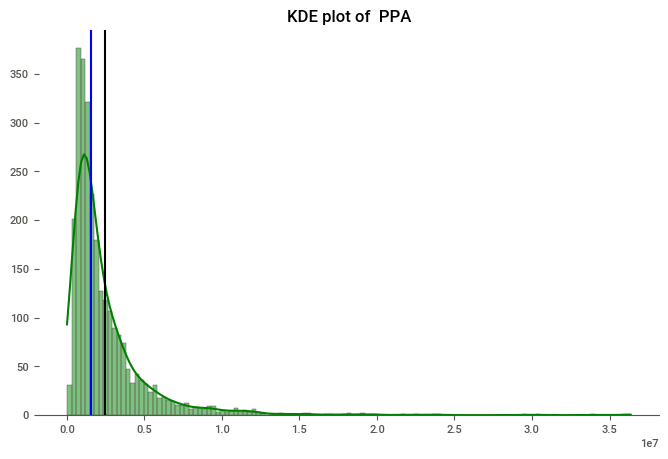

In [63]:
kde_plot('PPA')

The KDE shows that `PPA` is extremely right skewed and contains very large outlier. Therfore we cannot methods like z-score, as `PPA` does not behave normally. Instead, I will use the Median Absolute Deviation (MAD) technique. This is a robust method for distribution with a heavy outlier effect. More information on the MAD can be found [here](https://en.wikipedia.org/wiki/Median_absolute_deviation). I will calculate the MAD of `PPA`using the `scipy.stats` library below.

In [64]:
median_abs_deviation(df["PPA"])

788888.8888888889

Now, I filter dataset (removing outlier) based on the MAD technique. 

In [65]:
median_prices = {"Tokyo": median_abs_deviation(df["PPA"])}

#call province median from the dictionary
Median = median_prices["Tokyo"]
    
#difference between each price_per_area with the called median
df['Median_Diff'] = 0

for index, row in df.iterrows():
    median_diff = abs(row['PPA'] - Median)
    df.at[index, 'Median_Diff'] = median_diff
    
#calculate the median of new column
MAD = df['Median_Diff'].median()
    
#determine treshold
threshold = MAD * 3
    
#detect and filter rows based on outlier
df = df[~(df['Median_Diff'] > threshold)]
    
#remove the differenece column
df = df.drop(['Median_Diff'], axis=1)

In [66]:
df.shape

(2111, 14)

Note that the shape of the Dataframe has been reduced, an indication that outliers have been removed. We can check the KDE of `PPA` once again and visually confirm the removal of extreme outliers.

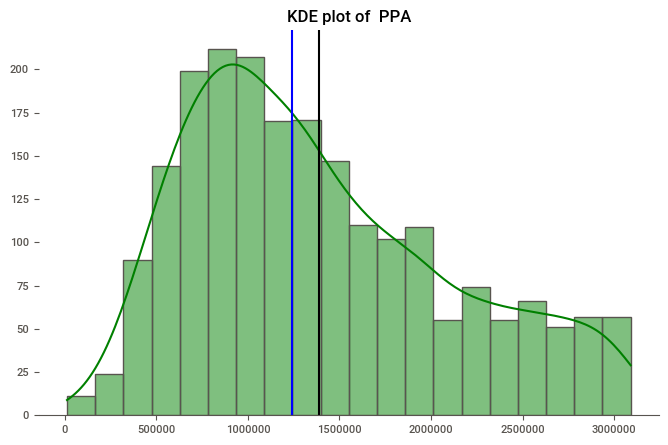

In [67]:
kde_plot('PPA')

Now that we removed outliers based on `PPA` we can remove the `PPA` column, reset the index, and proceed to save our processed dataframe using the `pickle` package. 

In [68]:
df=df.drop(['PPA'], axis=1)

In [69]:
df = df[df.Use != 'Parking Lot']

<hr>

### 4 - Saving Data using `pickle`

This concludes the first part of this project. Using the `pickle` package I will save our current dataframe. In the next part I will continue this project.

In [929]:
with open('TokyoSub_Final.pickle', 'wb') as file:
    pickle.dump(df, file)

<hr>